#### Importación de librerías y carga del dataset

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

train_df = pd.read_csv('../data/train.csv', sep=',')
test_df = pd.read_csv('../data/test.csv', sep=',')
sample_submission = pd.read_csv('../data/sample_submission.csv', sep=',')


#### Observación de dimensiones y contenido

In [2]:
print(train_df.shape)
train_df.head()

(700000, 26)


,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


In [3]:
print(test_df.shape)
test_df.head()

(300000, 25)


,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,triglycerides,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history
0,700000,45,4,100,4.3,6.8,6.2,25.5,0.84,123,...,111,Female,White,Highschool,Middle,Former,Employed,0,0,0
1,700001,35,1,87,3.5,4.6,9.0,28.6,0.88,120,...,145,Female,White,Highschool,Middle,Never,Unemployed,0,0,0
2,700002,45,1,61,7.6,6.8,7.0,28.5,0.94,112,...,184,Male,White,Highschool,Low,Never,Employed,0,0,0
3,700003,55,2,81,7.3,7.3,5.0,26.9,0.91,114,...,128,Male,White,Graduate,Middle,Former,Employed,0,0,0
4,700004,77,2,29,7.3,7.6,8.5,22.0,0.83,131,...,133,Male,White,Graduate,Low,Current,Unemployed,0,0,0


In [4]:
print(sample_submission.shape)
sample_submission.head()

(300000, 2)


,id,diagnosed_diabetes
0,700000,0
1,700001,0
2,700002,0
3,700003,0
4,700004,0


#### Tipos de datos y cantidad de datos no nulos por columna

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

#### Obervamos conteo de datos de casos de diabetes diagnosticada vs no diagnositicada. Parece que están bastante balanceados.

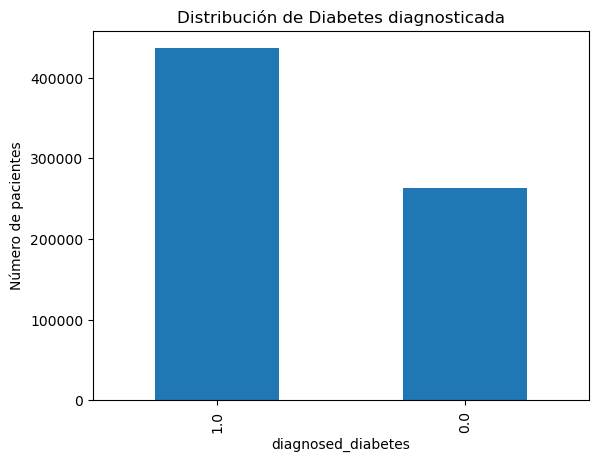

In [6]:
train_df['diagnosed_diabetes'].value_counts().plot(kind='bar', title='Distribución de Diabetes diagnosticada')
plt.ylabel('Número de pacientes')
plt.show()

###

In [7]:
# Proorción de clases
train_df['diagnosed_diabetes'].value_counts()/len(train_df)

diagnosed_diabetes
1.0    0.623296
0.0    0.376704
Name: count, dtype: float64

#### Calculo valores nulos. Observo que no hay.

In [8]:
train_df.isna().sum()

id                                    0
age                                   0
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    0
diet_score                            0
sleep_hours_per_day                   0
screen_time_hours_per_day             0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           0
diastolic_bp                          0
heart_rate                            0
cholesterol_total                     0
hdl_cholesterol                       0
ldl_cholesterol                       0
triglycerides                         0
gender                                0
ethnicity                             0
education_level                       0
income_level                          0
smoking_status                        0
employment_status                     0
family_history_diabetes               0
hypertension_history                  0
cardiovascular_history                0


#### Hago un describe para observar la distribución de los datos.

In [9]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,700000.0,349999.500000,202072.738554,0.00,174999.75,349999.50,524999.25,699999.00
age,700000.0,50.359734,11.655520,19.00,42.00,50.00,58.00,89.00
alcohol_consumption_per_week,700000.0,2.072411,1.048189,1.00,1.00,2.00,3.00,9.00
physical_activity_minutes_per_week,700000.0,80.230803,51.195071,1.00,49.00,71.00,96.00,747.00
diet_score,700000.0,5.963695,1.463336,0.10,5.00,6.00,7.00,9.90
sleep_hours_per_day,700000.0,7.002200,0.901907,3.10,6.40,7.00,7.60,9.90
screen_time_hours_per_day,700000.0,6.012733,2.022707,0.60,4.60,6.00,7.40,16.50
bmi,700000.0,25.874684,2.860705,15.10,23.90,25.90,27.80,38.40
waist_to_hip_ratio,700000.0,0.858766,0.037980,0.68,0.83,0.86,0.88,1.05
systolic_bp,700000.0,116.294193,11.010390,91.00,108.00,116.00,124.00,163.00


#### Creo variables para los datos de entrada y salida

In [10]:
# Descarto columnas irrelevantes
X = train_df.drop(columns=["diagnosed_diabetes", "id"])
# Target variable
y = train_df["diagnosed_diabetes"]

#### Separo variables categóricas y numéricas.

In [11]:
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols   = X.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)


Categorical: ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']
Numerical: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']


#### Genero los histogramas de las variables numéricas para ver su distribución.

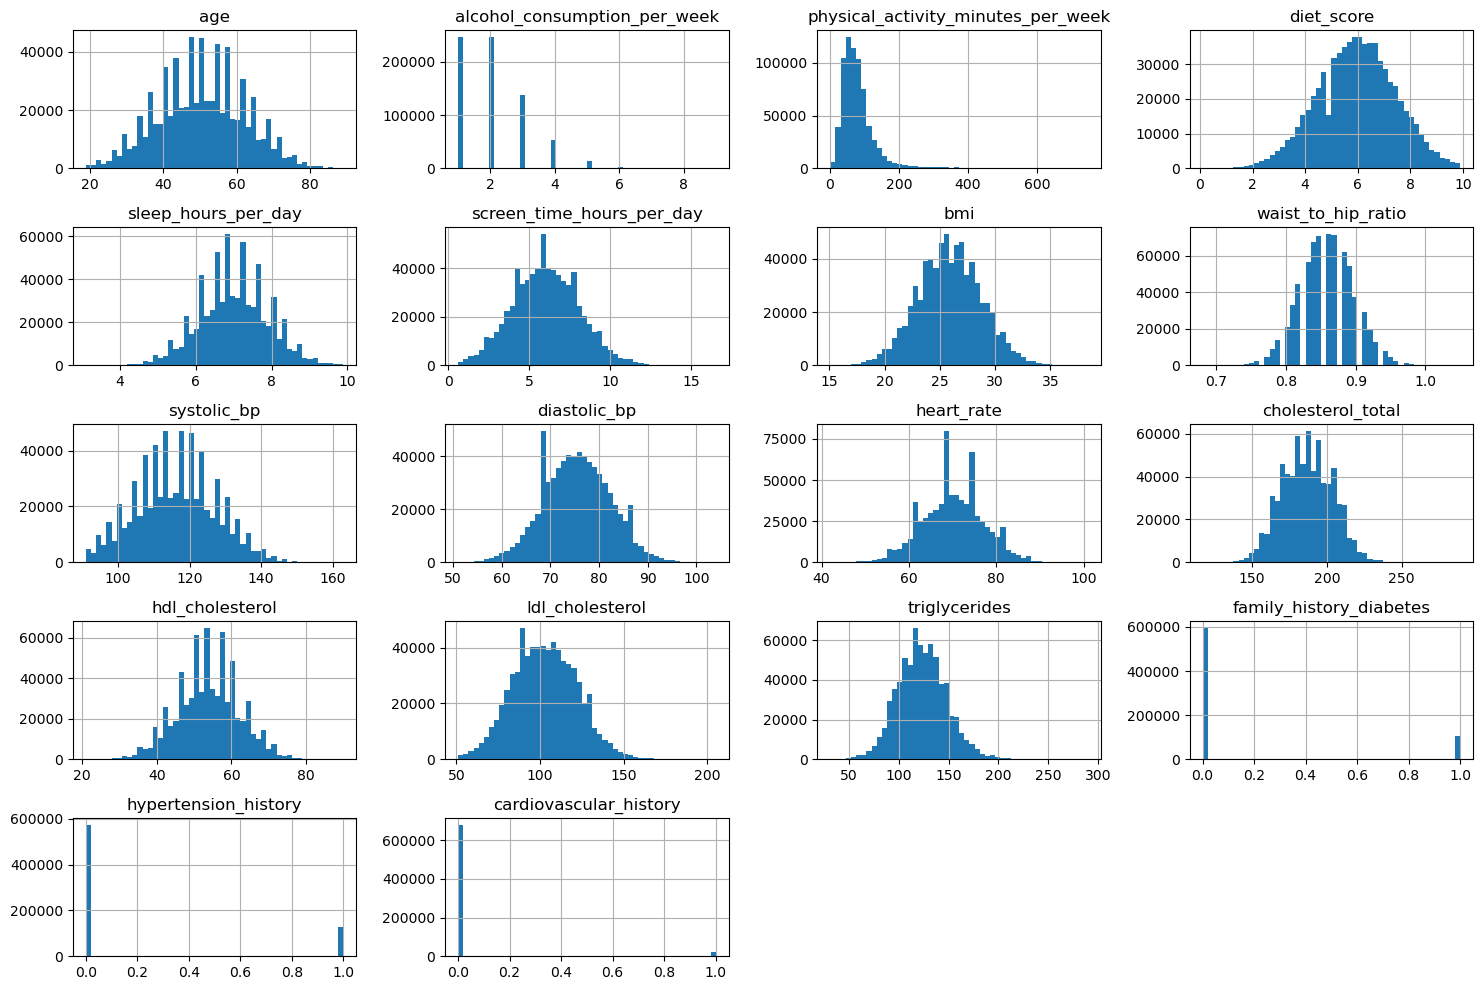

In [12]:
X[numerical_cols].hist(bins=50, figsize=(15, 10))
plt.tight_layout()
plt.show()

#### Genero diagramas de bigotes. Se pueden observar los outliers.

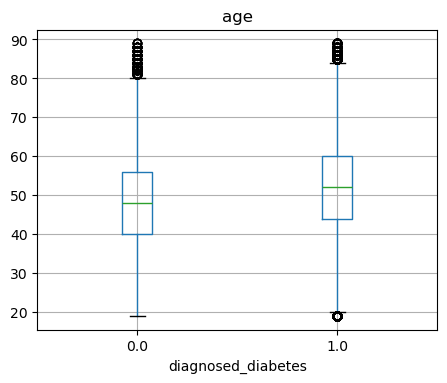

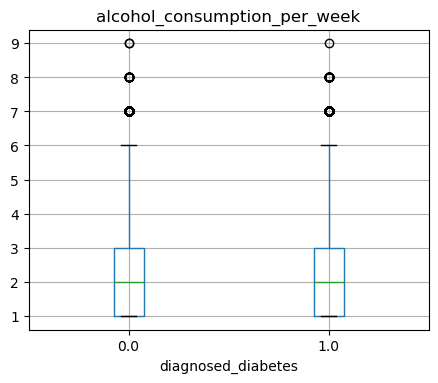

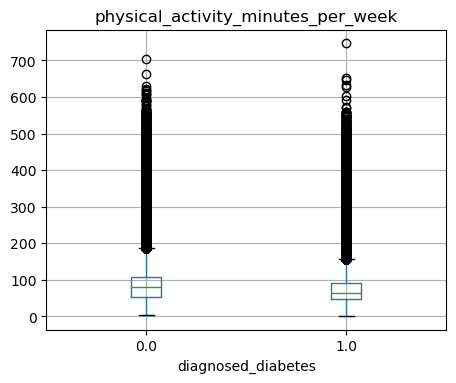

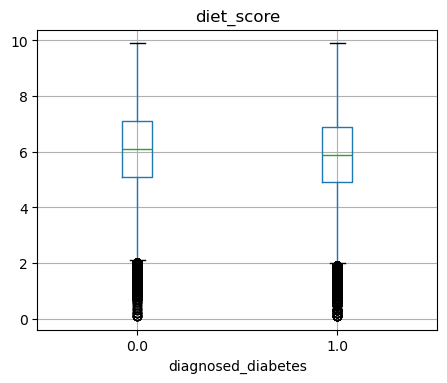

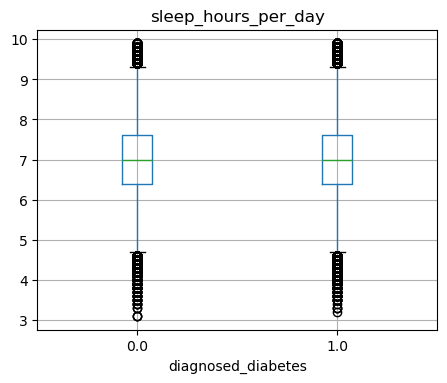

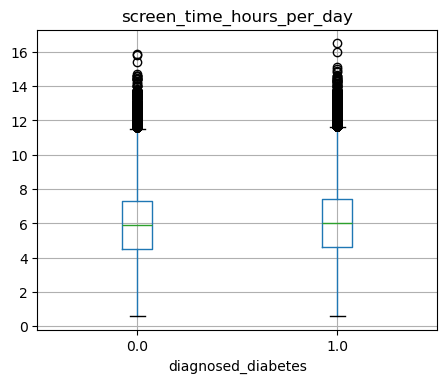

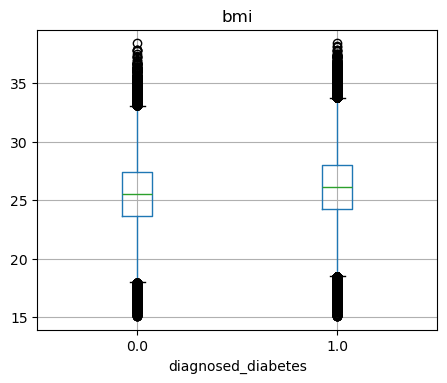

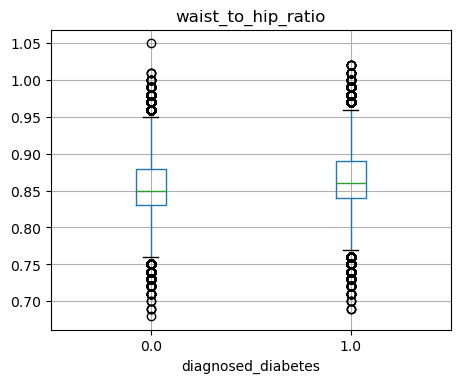

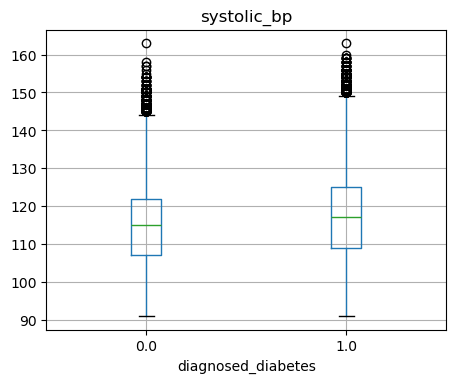

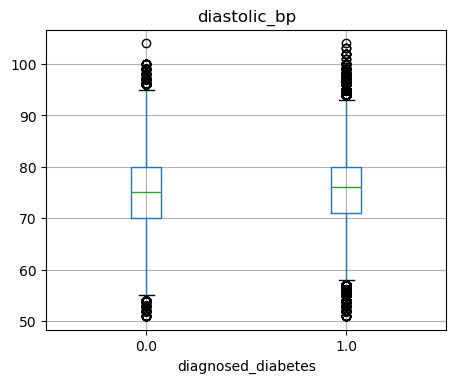

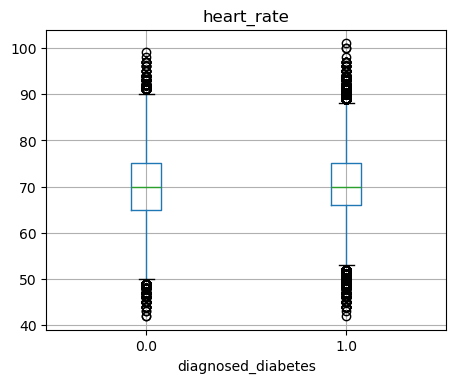

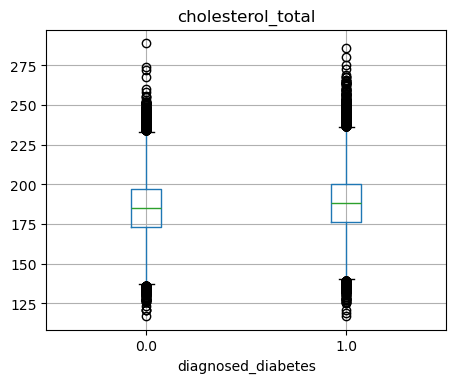

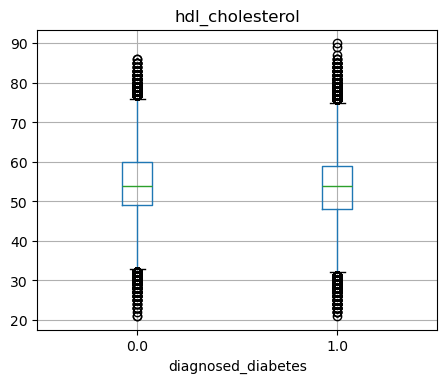

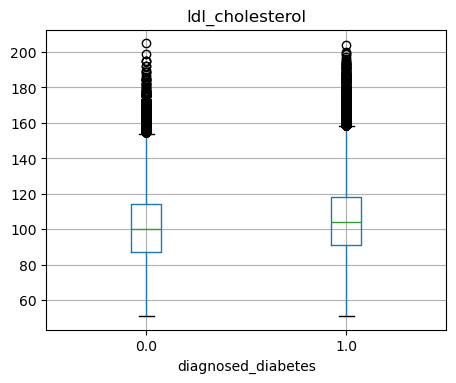

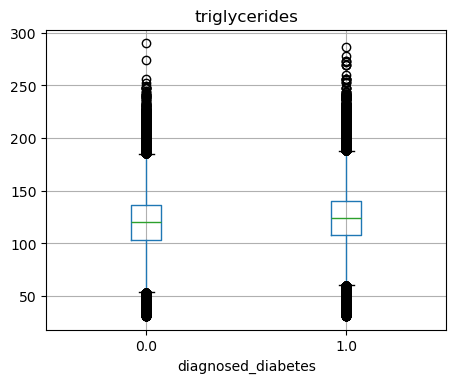

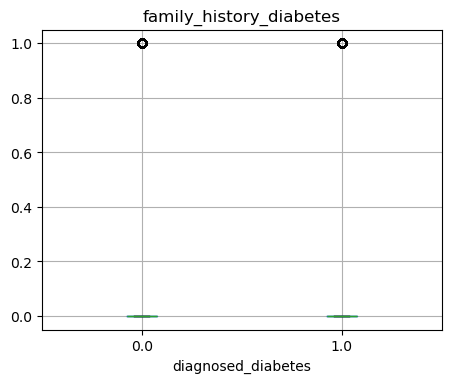

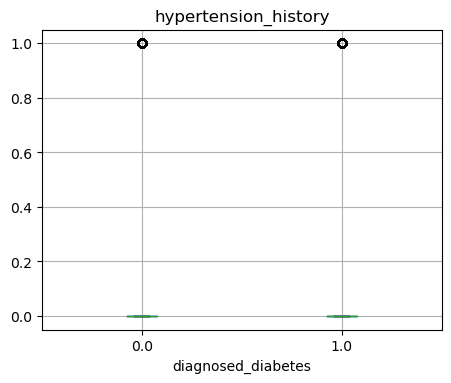

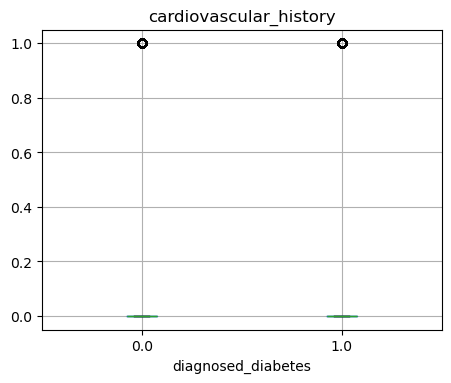

In [13]:
for col in numerical_cols:  
    train_df.boxplot(column=col, by="diagnosed_diabetes", figsize=(5, 4))
    plt.title(col)
    plt.suptitle('')
    plt.show()

#### Se observa que algunas columnas solo tienen valores 0 1, con lo cual se pueden separar como variables binarias en lugar de numéricas.

#### Calulo los porcentajes de las categorías de cada variable categórica para ver su distribución.

In [14]:
for col in categorical_cols:
    print(f"Column: {col}")
    print(X[col].value_counts(normalize=True))


Column: gender
gender
Female    0.518910
Male      0.475836
Other     0.005254
Name: proportion, dtype: float64
Column: ethnicity
ethnicity
White       0.551647
Hispanic    0.185691
Black       0.151859
Asian       0.085886
Other       0.024917
Name: proportion, dtype: float64
Column: education_level
education_level
Highschool      0.491636
Graduate        0.373240
Postgraduate    0.113774
No formal       0.021350
Name: proportion, dtype: float64
Column: income_level
income_level
Middle          0.415081
Lower-Middle    0.255100
Upper-Middle    0.182623
Low             0.122576
High            0.024620
Name: proportion, dtype: float64
Column: smoking_status
smoking_status
Never      0.706354
Current    0.147661
Former     0.145984
Name: proportion, dtype: float64
Column: employment_status
employment_status
Employed      0.737386
Retired       0.165336
Unemployed    0.071124
Student       0.026154
Name: proportion, dtype: float64


#### Genero gráficos de las cuentas de diagnosticos de diabetes para cada categoría.

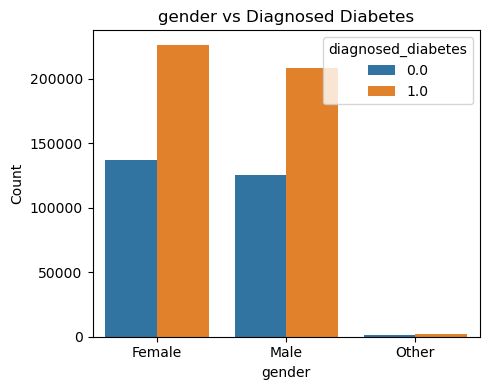

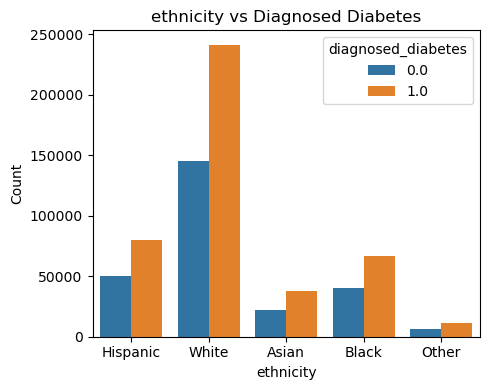

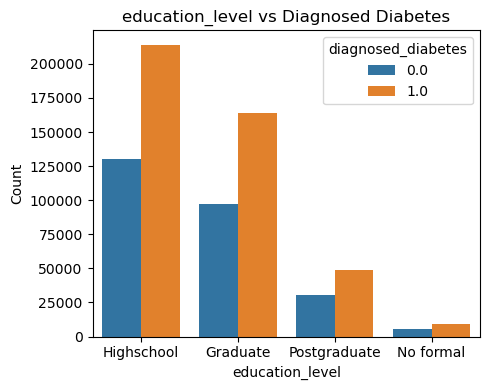

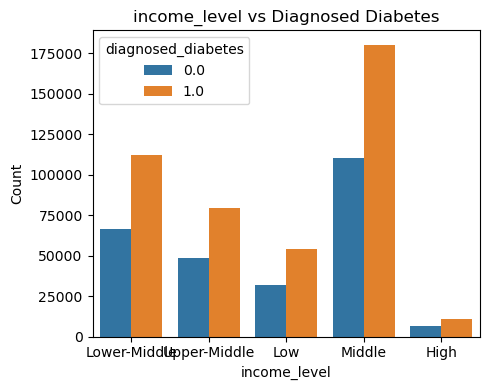

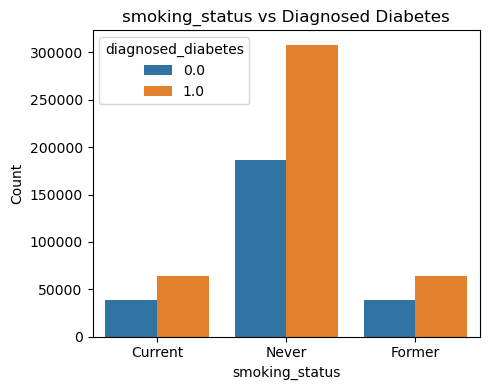

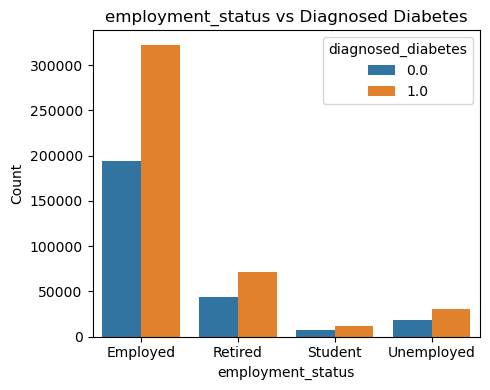

In [15]:
for col in categorical_cols:
    plt.figure(figsize=(5, 4))
    sns.countplot(data=train_df, x=col, hue='diagnosed_diabetes')
    plt.title(f"{col} vs Diagnosed Diabetes")
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

#### Separo variables binarias y genero gráficas para ver su distribución según los casos positivos y negativos de diabetes.

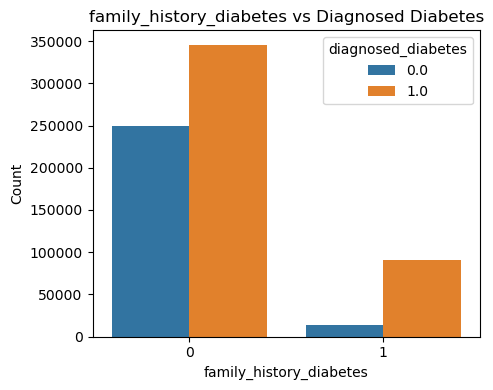

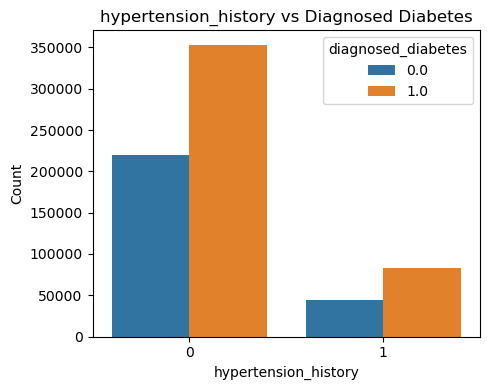

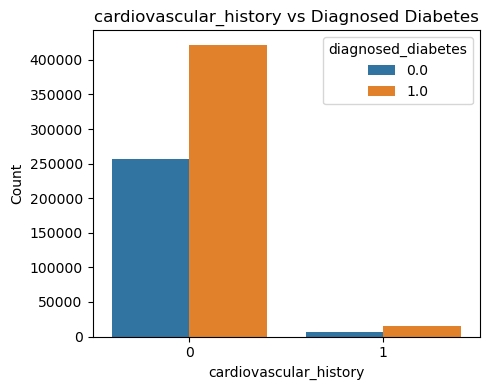

In [16]:
variables_binarias = ['family_history_diabetes', 'hypertension_history', 'cardiovascular_history']
for col in variables_binarias:
    plt.figure(figsize=(5, 4))
    sns.countplot(data=train_df, x=col, hue='diagnosed_diabetes')
    plt.title(f"{col} vs Diagnosed Diabetes")
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()    

#### Genero la matriz de correlaciones.

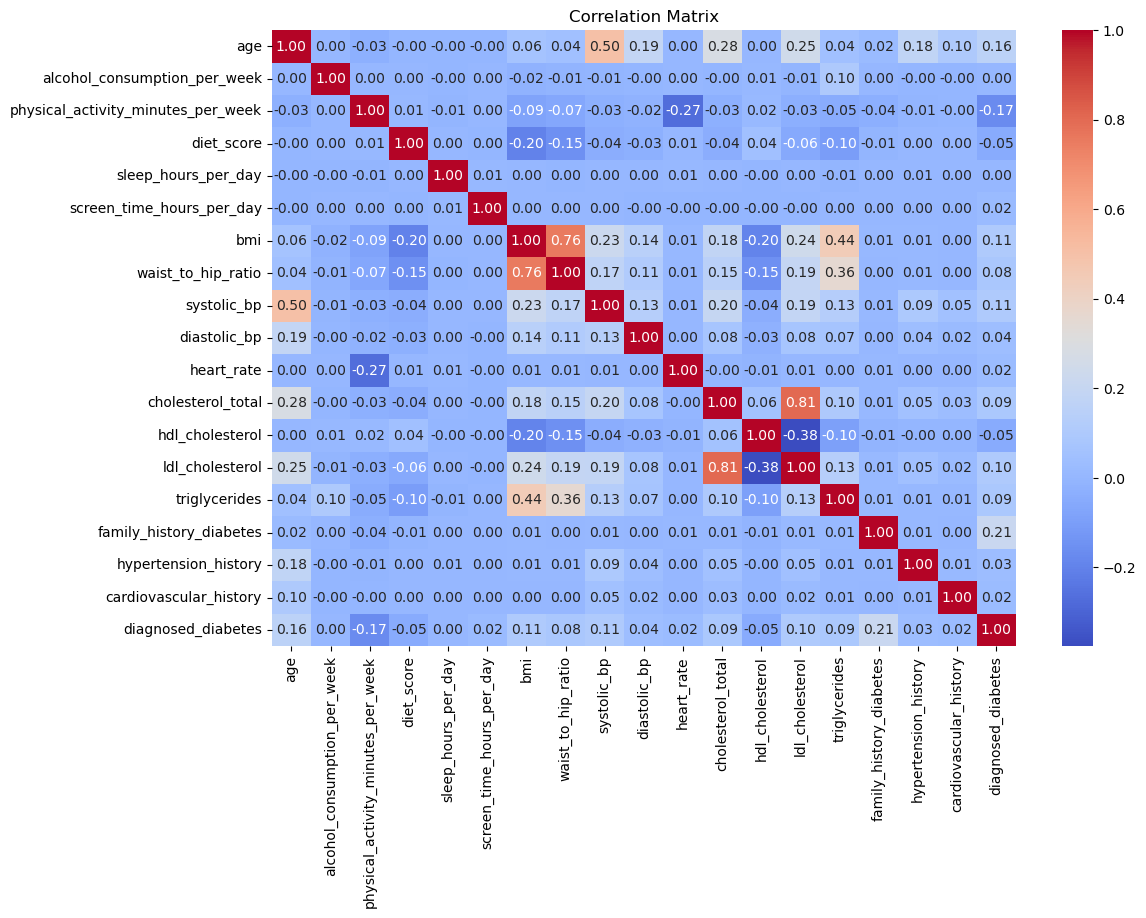

In [17]:
corr = train_df[numerical_cols + ['diagnosed_diabetes']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### Calculo los cuantiles q1 y q99 para ver cuantos valores son outliers.

In [18]:
for col in numerical_cols:
    q1 = train_df[col].quantile(0.01)
    q99 = train_df[col].quantile(0.99)
    print(f"{col}: [{q1:.2f}, {q99:.2f}]")


age: [25.00, 76.00]
alcohol_consumption_per_week: [1.00, 5.00]
physical_activity_minutes_per_week: [16.00, 304.00]
diet_score: [2.50, 9.30]
sleep_hours_per_day: [4.90, 9.10]
screen_time_hours_per_day: [1.50, 10.90]
bmi: [19.30, 32.60]
waist_to_hip_ratio: [0.77, 0.95]
systolic_bp: [93.00, 141.00]
diastolic_bp: [60.00, 91.00]
heart_rate: [54.00, 86.00]
cholesterol_total: [150.00, 225.00]
hdl_cholesterol: [35.00, 73.00]
ldl_cholesterol: [61.00, 148.00]
triglycerides: [67.00, 187.00]
family_history_diabetes: [0.00, 1.00]
hypertension_history: [0.00, 1.00]
cardiovascular_history: [0.00, 1.00]


#### En vista de todos los datos decido utilizar todas las variables de entrada.

#### Separa variables binarias de las numéricas.

In [19]:
binary_cols = [
    "family_history_diabetes",
    "hypertension_history",
    "cardiovascular_history"
]

numerical_cols = [
    col for col in X.columns
    if col not in categorical_cols + binary_cols
]

#### Búsqueda del mejor modelo. Preprocesamiento

In [20]:
# Preproceso los datos codificando categóricas, escalando numéricas y dejando binarias tal cual. Para el modelo LightGBM no es necesario escalar, pero lo incluyo para posibles futuros modelos.
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", "passthrough", numerical_cols), # no es necesario escalar para LightGBM
        ("bin", "passthrough", binary_cols)
    ]
)


#### Separo datos de entrenamiento y validación.

In [21]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)



### Pruebo a buscar mejores hiperparámetros con randomized search para el modelo LightGBM

In [22]:
# Elijo los hiperparámetros a probar en el random search para LightGBM
param_dist = {
    "model__n_estimators": [300, 500, 800, 1000],
    "model__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "model__num_leaves": [31, 63, 127],
    "model__max_depth": [-1, 6, 8, 10],
    "model__min_child_samples": [20, 50, 100, 200],
    "model__subsample": [0.7, 0.8, 0.9],
    "model__colsample_bytree": [0.7, 0.8, 0.9],
}


#### Selecciono el modelo a utilizar en el random search y creo un pipeline con el preprocesado.

In [23]:
lgb_model = lgb.LGBMClassifier(
    objective="binary",
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", lgb_model)
    ]
)


#### Ejecuto el random search y entreno el modelo.

In [24]:
lgb_model_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=3,
    verbose=0,
    random_state=42,
    n_jobs=-1,
)

lgb_model_search.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 232697, number of negative: 140636
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1666
[LightGBM] [Info] Number of data points in the train set: 373333, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623296 -> initscore=0.503562
[LightGBM] [Info] Start training from score 0.503562
[LightGBM] [Info] Number of positive: 232697, number of negative: 140636
[LightGBM] [Info] Number of positive: 232698, number of negative: 140636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 232697, number of negative: 140636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead o

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 232698, number of negative: 140636
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1667
[LightGBM] [Info] Number of data points in the train set: 373334, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623297 -> initscore=0.503566
[LightGBM] [Info] Start training from score 0.503566
[LightGBM] [Info] Number of positive: 232697, number of negative: 140636
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1669
[LightGBM] [Info] Number of data points in the train set: 373333, number of used features: 42
[LightGBM] [In

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1666
[LightGBM] [Info] Number of data points in the train set: 373333, number of used features: 42[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623296 -> initscore=0.503562
[LightGBM] [Info] Start training from score 0.503562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 232698, number of negative: 140636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choo

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 232697, number of negative: 140636
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1666
[LightGBM] [Info] Number of data points in the train set: 373333, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623296 -> initscore=0.503562
[LightGBM] [Info] Start training from score 0.503562
[LightGBM] [Warning] No further splits with positive gain, best ga

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 232697, number of negative: 140636
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1669
[LightGBM] [Info] Number of data points in the train set: 373333, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623296 -> initscore=0.503562
[LightGBM] [Info] Start training from score 0.503562
[LightGBM] [Info] Number of positive: 232697, number of negative: 140636
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1666
[LightGBM] [Info] Number of data points in the train set: 373333, number of used features: 42
[LightGBM] [In

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 232698, number of negative: 140636
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1667
[LightGBM] [Info] Number of data points in the train set: 373334, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623297 -> initscore=0.503566
[LightGBM] [Info] Start training from score 0.503566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 349046, number of negative: 210954
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1672
[LightGBM] [Info] Number of data points in the train set: 560000, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623296 -> initscore=0.503564
[LightGBM] [Info] Start training from score 0.503564


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'model__colsample_bytree': [0.7, 0.8, ...], 'model__learning_rate': [0.01, 0.03, ...], 'model__max_depth': [-1, 6, ...], 'model__min_child_samples': [20, 50, ...], ...}"
,n_iter,20
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


#### Obtengo el valor de ROC-AUC y los mejores hiperparámetros del modelo.

In [25]:
print("Best ROC-AUC:", lgb_model_search.best_score_)
print("Best params:")
lgb_model_search.best_params_

Best ROC-AUC: 0.7261345286092098
Best params:


{'model__subsample': 0.9,
 'model__num_leaves': 31,
 'model__n_estimators': 1000,
 'model__min_child_samples': 100,
 'model__max_depth': 10,
 'model__learning_rate': 0.05,
 'model__colsample_bytree': 0.7}

#### Selecciono el mejor modelo.

In [26]:
best_model_lgb = lgb_model_search.best_estimator_

#### Curva ROC-AUC

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


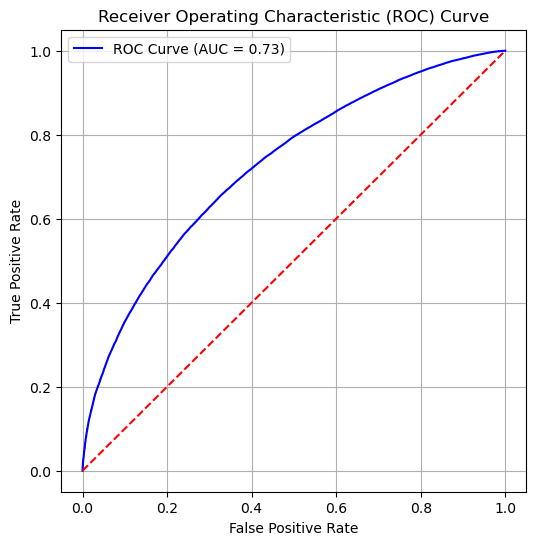

In [38]:
y_val_pred_prob = best_model_lgb.predict_proba(X_val)[:, 1] # Probabilidades de la clase positiva
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.grid(True)
plt.legend()
plt.show()

#### Selección del Threshold para calcular métricas y matriz de decisión.

In [79]:
# Calculo el threshold que maximiza la precisión manteniendo un recall mínimo del 96%
y_val_pred_prob = best_model_lgb.predict_proba(X_val)[:, 1] # Probabilidades de la clase positiva
thresholds = np.linspace(0, 1, 101) # umbrales de 0.0 a 1.0
min_recall = 0.965       

candidates = []

for t in thresholds:
    y_pred = (y_val_pred_prob >= t).astype(int)
    rec = recall_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, zero_division=0)

    if rec >= min_recall:
        candidates.append((t, rec, prec))

best_threshold, best_recall, best_precision = max(
    candidates, key=lambda x: x[2]
)

print(f"Threshold elegido: {best_threshold:.2f}")
print(f"Recall: {best_recall:.3f}")
print(f"Precision: {best_precision:.3f}")


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Threshold elegido: 0.35
Recall: 0.969
Precision: 0.653


#### Calculo las métricas para el Threshold seleccionado.

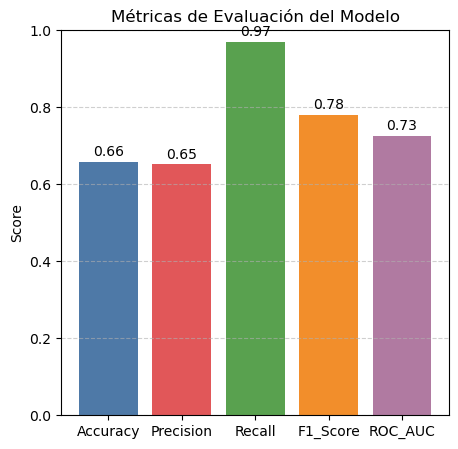

Accuracy  : 0.6591357142857143
Precision : 0.6526405188387894
Recall    : 0.9687030861438672
F1_Score  : 0.7798653941074172
ROC_AUC   : 0.7266904515174614


In [80]:
# Evaluación y métricas
y_pred_th = y_val_pred_prob >= best_threshold
accuracy = accuracy_score(y_val, y_pred_th)
precision = precision_score(y_val, y_pred_th)
recall = recall_score(y_val, y_pred_th)
F1_score = f1_score(y_val, y_pred_th)
roc_auc = roc_auc_score(y_val, y_val_pred_prob)
metrics = {
    "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1_Score": F1_score, "ROC_AUC": roc_auc
}

colors = ["#4E79A7", "#E15759",  "#59A14F", "#F28E2B", "#B07AA1"] 

plt.figure(figsize=(5,5))
bars = plt.bar(metrics.keys(), metrics.values(), color=colors)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height * 1.01, 
        f'{height:.2f}', 
        ha='center', 
        va='bottom',
        fontsize=10
    )

plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Métricas de Evaluación del Modelo')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

print("Accuracy  :", accuracy)
print("Precision :", precision)
print("Recall    :", recall)
print("F1_Score  :", F1_score)
print("ROC_AUC   :", roc_auc)

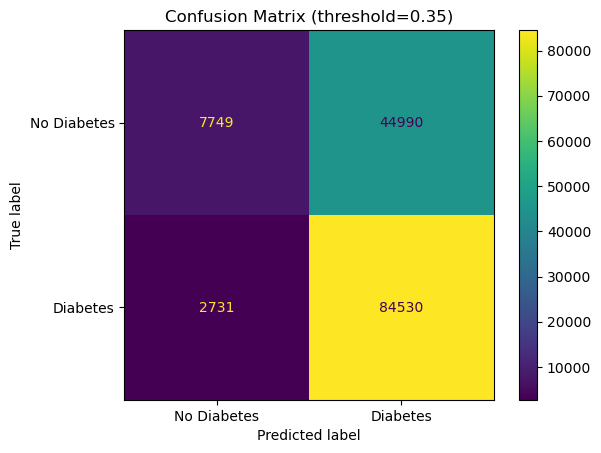

In [81]:
cm = confusion_matrix(y_val, y_pred_th)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Diabetes", "Diabetes"]
)

disp.plot(values_format="d")
plt.title(f"Confusion Matrix (threshold={best_threshold:.2f})")
plt.show()

### Conclusiones:

- Obtenemos una sensibilidad muy alta que es el objetivo principal. Alrededor del 95.3% de los pacientes con diabetes son detectados.
- El modelo sobrediagnostica diabetes, baja la accuracy y la precision a cambio de protoger contra falsos negativos.
- Precision del 66% inidica de que 2 de cada 3 alertas son casos reales
- Accuracy baja porque el modelo no intenta ser equilibrado. El modelo no intenta maximizar el número total de aciertos, sino minimizar los falsos negativos aceptando muchos falsos positivos.
- F1-score 0.78 indica un buen equilibrio entre precision y recall dadas las prioridades
- ROC-AUC de 0.73 significa que, si tomamos al azar un paciente con diabetes y uno sin diabetes, el modelo asigna una probabilidad mayor al paciente con diabetes en el 73% de los casos.
- Muchos falsos negativos implica que se requiere confirmación clínica posterior

El modelo alcanza una sensibilidad superior al 95%, lo que permite identificar la gran mayoría de los pacientes con diabetes. Aunque esto conlleva una tasa moderada de falsos positivos, dicho comportamiento es coherente con un enfoque de cribado, donde se prioriza minimizar la omisión de casos reales frente a la generación de alertas adicionales que pueden ser confirmadas clínicamente.

#### Por último entreno el modelo con todos los datos de train.csv y calculo la predicción con los datos de test.csv. Genero un archivo con la predicción.

In [ ]:
#Entreno el modelo final con todos los datos de entrenamiento. No hay que usar el preprocesador porque ya está incluido en el pipeline.
best_model_lgb.fit(X, y)

#Guardo el modelo entrenado
import joblib   
joblib.dump(best_model_lgb, '../results/best_model_lgb.joblib')

# Predicciones sobre el conjunto de test
X_sample_test = test_df.drop(columns=["id"])
y_sample_test_pred_prob = best_model_lgb.predict_proba(X_sample_test)[:, 1]

# Generación del archivo de submission
submission = sample_submission.copy()
submission['diagnosed_diabetes'] = y_sample_test_pred_prob
submission.to_csv('../data/submission_lightgbm.csv', index=False)


[LightGBM] [Info] Number of positive: 436307, number of negative: 263693
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1667
[LightGBM] [Info] Number of data points in the train set: 700000, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623296 -> initscore=0.503561
[LightGBM] [Info] Start training from score 0.503561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
